In [255]:
%matplotlib inline 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(16,9))
import numpy as np
import tifffile
from scipy import ndimage as ndi
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
import skimage as ski
import pathlib
from stardist import random_label_cmap, render_label
cmap = random_label_cmap()

from keras.models import model_from_json

import tensorflow as tf
from tensorflow import keras
from csbdeep.utils import normalize
from csbdeep.internals.nets import custom_unet 

from skimage.future import graph


In [3]:
rooth = pathlib.Path('/home/vanvliet/data/Dataset/')
out_dir = pathlib.Path("unet_day4_aug_weighted")
save_dir = pathlib.Path('/home/vanvliet/embl2021_group_3/simon/models/')/out_dir


fnames_x_all = sorted((rooth/'phaseImg').glob('*.tif'))
fnames_y_all = sorted((rooth/'labelImg').glob('*.tif'))

fnames_x_val = sorted((rooth/'phaseImg').glob('d09*.tif'))
fnames_y_val = sorted((rooth/'labelImg').glob('d09*.tif'))

fnames_x_test = sorted((rooth/'phaseImg').glob('d10*.tif'))
fnames_y_test = sorted((rooth/'labelImg').glob('d10*.tif'))

fnames_x_train = sorted(tuple(set(fnames_x_all) - set(fnames_x_val) - set(fnames_x_test)))
fnames_y_train = sorted(tuple(set(fnames_y_all) - set(fnames_y_val) - set(fnames_y_test)))

In [189]:
# load weights into new model
model = custom_unet((None,None,1),last_activation='softmax',kernel_size=(3,3),pool_size=(4,4),n_channel_out=3,n_depth=3,n_filter_base=32)
model.load_weights((save_dir / 'weights.h5'))

In [389]:
def image_loader(fx, fy, i=None):
    n = len(fx)
    devider = 64
    if i is None:
        i = np.random.randint(n)    
    x, y = tifffile.imread(fx[i]), tifffile.imread(fy[i])
    new_shape = (np.asarray(x.shape) // devider) * devider
    offset = np.ceil((x.shape - new_shape)/2)
    crop = [slice(r,r+c) for r,c in zip(offset.astype(np.int),new_shape.astype(np.int))]
    x = normalize(x[tuple(crop)],1,99.8)
    y = y[tuple(crop)]
    return x, y

def plot_pairs(x,y):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x)
    ax[1].imshow(y)
    
def plot_many(x):
    n = len(x)
    fig, ax = plt.subplots(1,n)
    for i,_x in enumerate(x):
        ax[i].imshow(_x)

def plot_many_lables(x):
    n = len(x)
    fig, ax = plt.subplots(1,n)
    for i,_x in enumerate(x):
        ax[i].imshow(_x, cmap=cmap, interpolation='none')       
        
    
def plot_seg_check(x,y,l):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(x)
    ax[0].set_title('raw data')
    ax[1].imshow(y, cmap=cmap, interpolation='none')
    ax[1].set_title('ground truth')
    ax[2].imshow(l, cmap=cmap, interpolation='none')
    ax[2].set_title('prediction')
#     ax[1].imshow(render_label(y,img=x*0.6+0.3,cmap=cmap,normalize_img=False))
#     ax[1].set_title('ground truth')   
#     ax[2].imshow(render_label(y,img=x*0.6+0.3,cmap=cmap,normalize_img=False))
#     ax[2].set_title('prediction')



In [487]:
def process_segmentation(p):
    interior = p[0,...,1]
    edges = p[0,...,2]
    cells = interior + edges
    markers = label(interior>0.95) #was 0.9
    distance = ndi.distance_transform_edt(edges<0.5)
    mask = cells>0.8 #was 0.7
    labels = watershed(-distance, markers=markers, mask=mask)    
    
    rag = graph.rag.rag_boundary(labels,edges,connectivity=2)
    labels_merged = graph.cut_threshold(labels, rag, 0.4, in_place=False) #used 0.88 for large set

    return labels




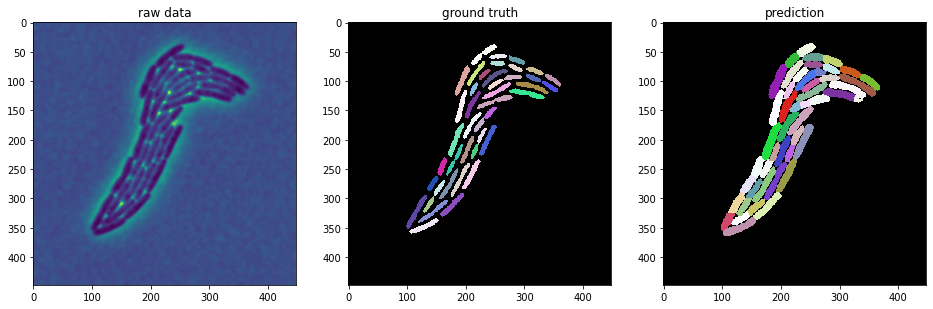

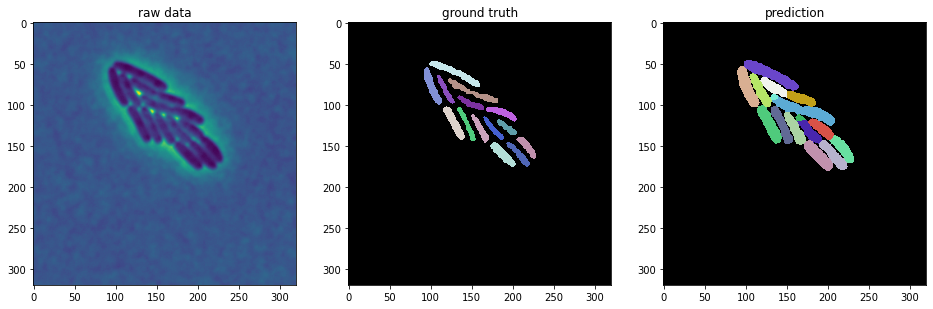

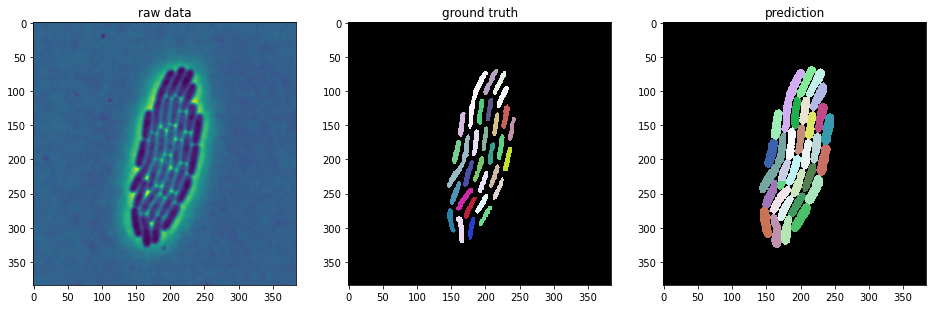

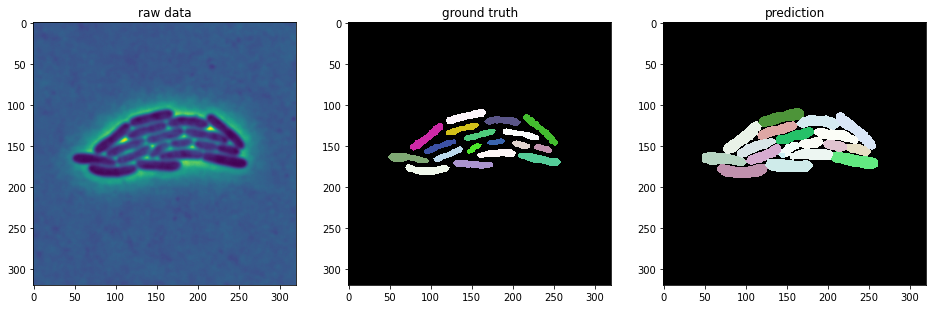

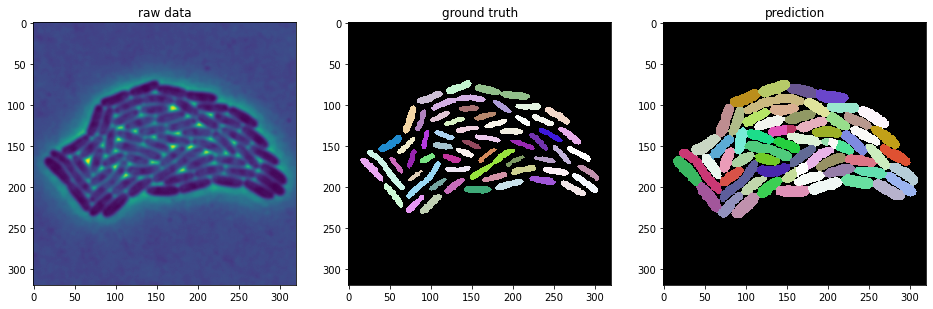

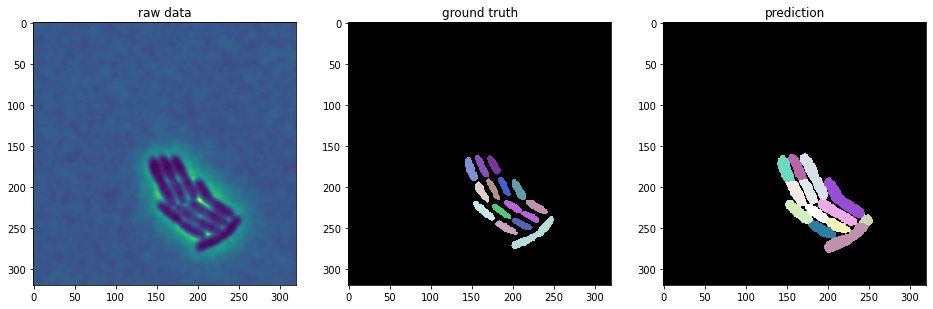

In [488]:
plotting = True
counter = 0
while plotting:
    x,y = image_loader(fnames_x_test, fnames_y_test)
    p = model.predict(x[np.newaxis,...,np.newaxis])
    l = process_segmentation(p)
    nCel = len(np.unique(l))
    if nCel > 10:
        plot_seg_check(x,y,l)
        counter += 1
        if counter>5:
            plotting = False
    


In [481]:
getdata = True
counter = 0
data_to_test = 'd09e02*.tif'
fnames_x_par_test = sorted((rooth/'phaseImg').glob(data_to_test))
fnames_y_par_test = sorted((rooth/'labelImg').glob(data_to_test))
    
    
while getdata:
    x,y = image_loader(fnames_x_par_test, fnames_y_par_test,40)
    nCel = len(np.unique(y))
    if nCel > 10:
        p = model.predict(x[np.newaxis,...,np.newaxis])
        getdata = False

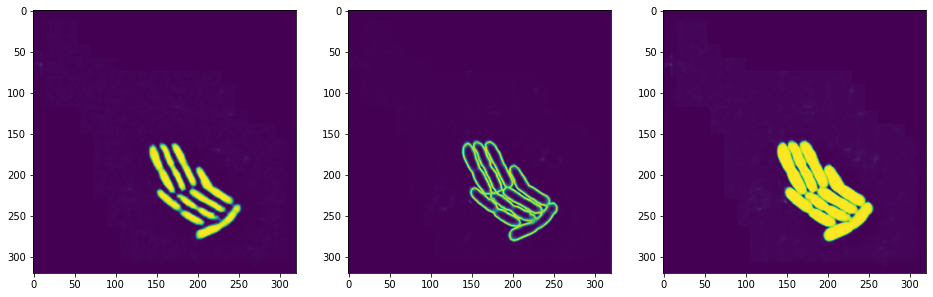

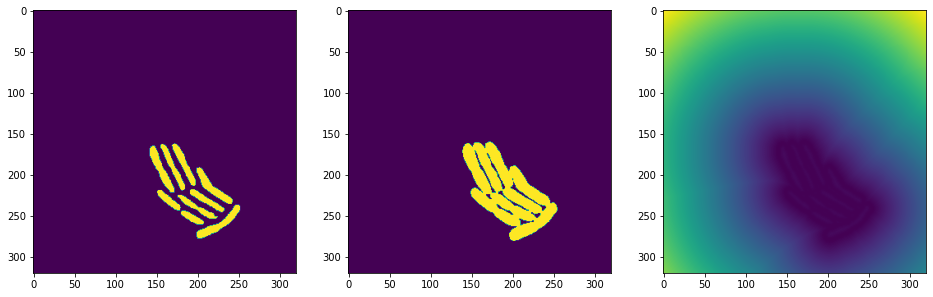

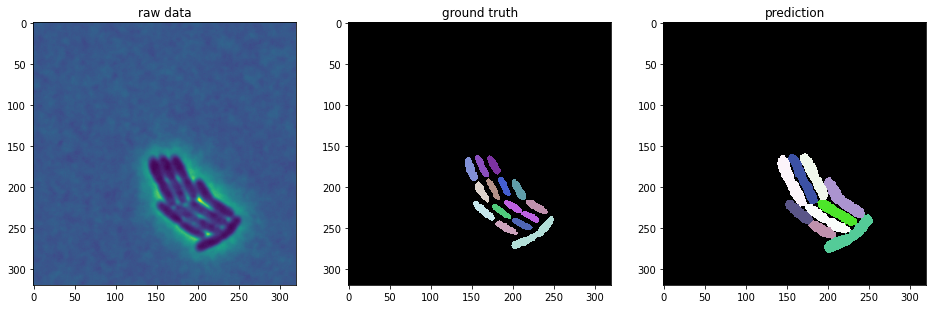

In [494]:
interior = p[0,...,1]
edges = p[0,...,2]
cells = interior + edges
markers = label(interior>0.6)
distance = ndi.distance_transform_edt(edges<0.5)
mask = cells>0.8
labels = watershed(-distance, markers=markers, mask=mask)  

plot_many([interior,edges,cells])
plot_many([markers>0,mask,distance])
plot_seg_check(x,y,labels)

In [495]:
print(labels.shape, x.shape, edges.shape)

(320, 320) (320, 320) (320, 320)


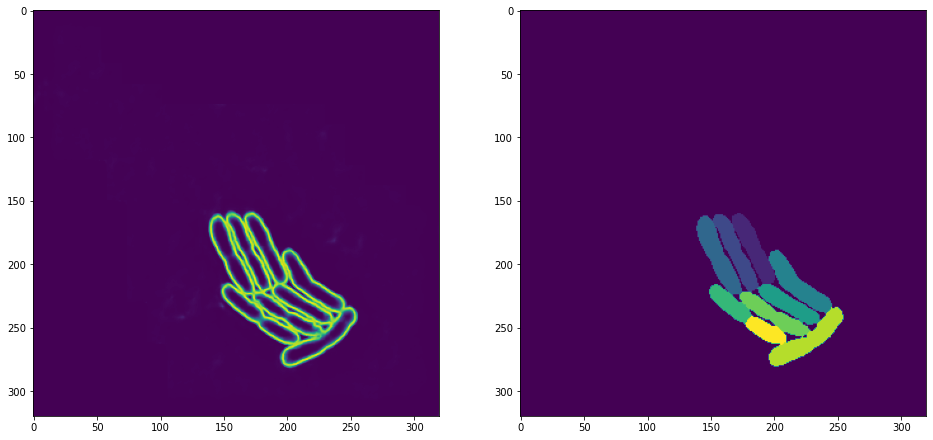

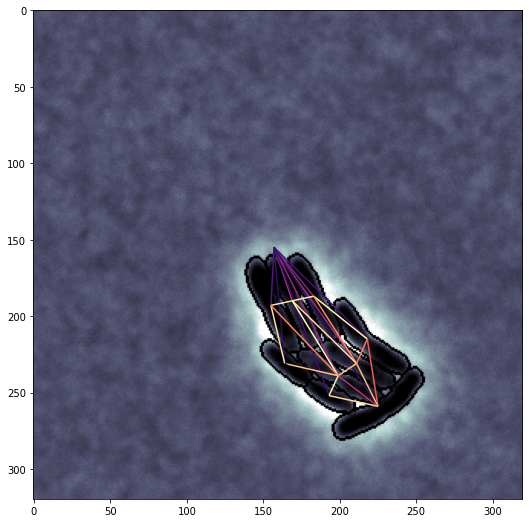

In [496]:
rag = graph.rag.rag_boundary(labels,edges,connectivity=2)
plot_many((edges,labels))
graph.show_rag(labels, rag, x) 

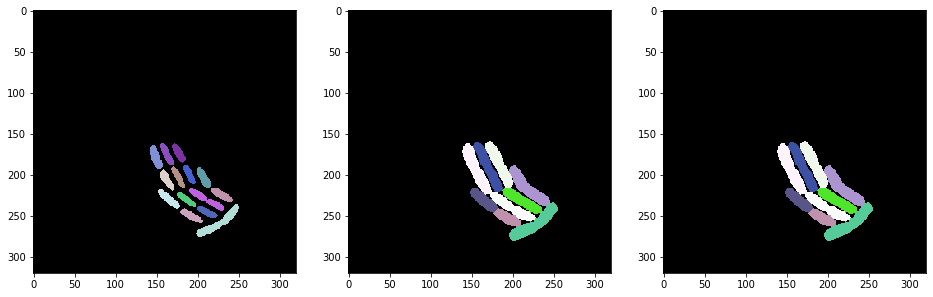

In [497]:
labels_merged = graph.cut_threshold(labels, rag, 0.4, in_place=False)
plot_many_lables((y,labels,labels_merged))

In [454]:
def export_data(fnames_x,fnames_y,movie_path):
    
    save_dir_pred = pathlib.Path('/home/vanvliet/predicted_labels/')
    save_dir_movies = pathlib.Path('/home/vanvliet/movies/')
    
    for i in range(len(fnames_x)):
        x,y = image_loader(fnames_x, fnames_y, i)
        p = model.predict(x[np.newaxis,...,np.newaxis])
        l = process_segmentation(p)
        
        tifffile.imwrite(save_dir_pred / fnames_x[i].name, data=l)
        
        fname_out_movie = movie_path / (fnames_x[i].stem+'_movie.tif')
        save_movie_frame(x,y,l,fname_out_movie)
    return None
 
def save_movie_frame(x,y,l,save_name):
    x[x>1] = 1
    x[x<0] = 0
    ph = ski.color.gray2rgb(x)
    gt = ski.color.label2rgb(y, bg_label=0)
    la = ski.color.label2rgb(l, bg_label=0)
    ph = ski.util.img_as_ubyte(ph)
    gt = ski.util.img_as_ubyte(gt)
    la = ski.util.img_as_ubyte(la)

    composite = np.concatenate((ph,gt,la),axis=1)
    tifffile.imwrite(save_name, data=composite)
    return None


    

In [491]:

dataset_list = ['d09e02']
for dataset in dataset_list:
    search_string  = dataset +'*.tif'
    movie_path =  pathlib.Path('/home/vanvliet/movies/') / (dataset + "_optimized")
    if not movie_path.exists():
        os.mkdir(movie_path)
    fnames_x_export = sorted((rooth/'phaseImg').glob(dataset+'*.tif'))
    fnames_y_export = sorted((rooth/'labelImg').glob(dataset+'*.tif'))
    export_data(fnames_x_export,fnames_y_export, movie_path)

In [498]:
cmap = cmap.shape()

AttributeError: 'ListedColormap' object has no attribute 'shape'